In [1]:
# Imports
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
from load_data import (
    get_without_time,
    used_resources,
    reserved_resources,
    lost_resources,
    lost_resources_by_label,
    stolen_resources,
    reserved_resources_by_label,
    used_resources_by_label,
)
from colors import colors_label, get_color, colors_palette
from constants import COMPUTING_RESOURCES, ARCHITECTURES
import squarify

/Users/thibaultsimon/Documents/projects/thesis/3_ecodesign/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/thibaultsimon/Documents/projects/thesis/3_ecodesign/load_data.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[label][result[label] < 0] = 0
/Users/thibaultsimon/Documents/projects/thesis/3_ecodesign/load_data.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[label][result[label] < 0] = 0

In [2]:
# Constants
FIG_WIDTH = 15
FIG_HEIGHT = 5
FIG_SIZE = (FIG_WIDTH, FIG_HEIGHT)
BENCH_NB = 2

RESERVED_COLOR = "firebrick"
USED_COLOR = "steelblue"

matplotlib.rcParams["pdf.fonttype"] = 42

# Lost resources definition


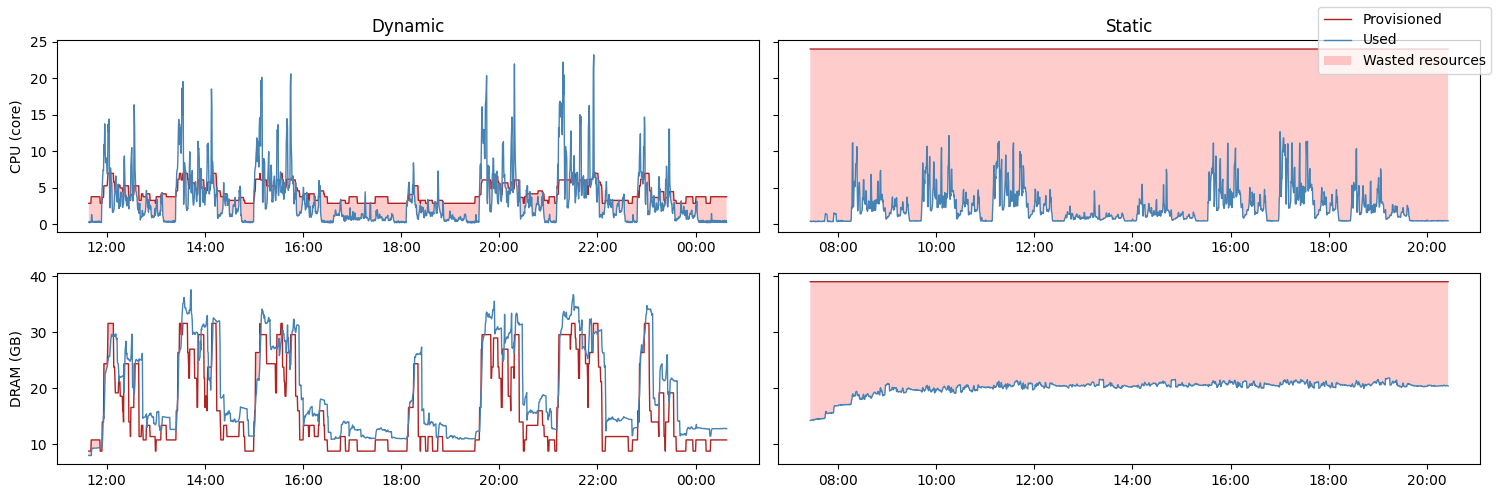

In [3]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=False, sharey="row")

row = 0
col = 0

for computing_resource in COMPUTING_RESOURCES:
    for architecture in ARCHITECTURES:
        reserved = reserved_resources[architecture]
        used = used_resources[architecture]
        ax = axes[row, col]
        ax.plot_date(
            reserved["Time"],
            reserved[computing_resource],
            "-",
            label="Provisioned",
            linewidth=1,
            color=RESERVED_COLOR,
        )
        ax.plot_date(
            used["Time"],
            used[computing_resource],
            "-",
            label="Used",
            linewidth=1,
            color=USED_COLOR,
        )

        ax.fill_between(
            reserved["Time"],
            reserved[computing_resource],
            used[computing_resource],
            where=reserved[computing_resource] >= used[computing_resource],
            facecolor="red",
            alpha=0.2,
            interpolate=True,
            label="Wasted resources",
        )
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
        if row == 0:
            if architecture == "KVM":
                ax.set_title("Static")
            else:
                ax.set_title("Dynamic")
        if col == 0:
            if computing_resource == "CPU":
                ax.set_ylabel("CPU (core)")
            else:
                ax.set_ylabel("DRAM (GB)")
        col += 1

    row += 1
    col = 0

fig.set_size_inches(FIG_SIZE)
# plt.xlabel("Time")
# plt.title('Lost resources')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
# fig.suptitle("Lost resources")

# plt.xlim(left=0)
# plt.ylim(bottom=0)
plt.tight_layout()
# plt.show()

plt.gcf().savefig("figures/wasted_resources/wasted_resources.pdf", bbox_inches="tight")
# plt.gcf().savefig("figures/wasted_resources/lost_resources.png",bbox_inches='tight')

In [4]:
df = pd.DataFrame(columns=["Reservation", "cpu", "ram"])

# df.append('oui', 'ram', 3, 4)

for architecture in ARCHITECTURES:
    df = pd.concat(
        [
            df,
            pd.DataFrame(
                {
                    "Reservation": ("Static" if architecture == "KVM" else "Dynamic"),
                    # "computing_resource": computing_resource,
                    "cpu": lost_resources[architecture][COMPUTING_RESOURCES[0]],
                    "ram": lost_resources[architecture][COMPUTING_RESOURCES[1]],
                }
            ),
        ],
        ignore_index=True,
    )

df

,Reservation,cpu,ram
0,Dynamic,2.570651,0.769334
1,Dynamic,2.510434,0.795691
2,Dynamic,2.669235,0.791518
3,Dynamic,2.500935,0.796347
4,Dynamic,2.629571,0.789523
...,...,...,...
3117,Static,23.519143,18.512998
3118,Static,23.505200,18.559521
3119,Static,23.532800,18.578252
3120,Static,23.524400,18.615181


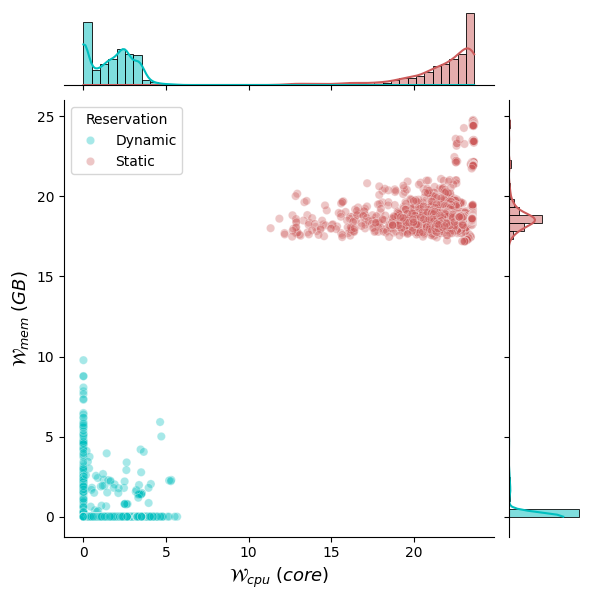

In [5]:
g = sns.JointGrid(data=df, x="cpu", y="ram", hue="Reservation")
g.plot_joint(sns.scatterplot, alpha=0.35, palette=colors_palette)
g.plot_marginals(sns.histplot, binwidth=0.5, kde=True, palette=colors_palette)

g.ax_joint.set_xlabel(r"$\mathcal{W}_{cpu}$ $(core)$", fontsize=13)
g.ax_joint.set_ylabel(r"$\mathcal{W}_{mem}$ $(GB)$", fontsize=13)

plt.gcf().savefig("figures/wasted_resources/wasted_comparison.pdf", bbox_inches="tight")

In [6]:
df = pd.DataFrame(columns=["Reservation", "lost", "used"])

for architecture in used_resources:
    df = pd.concat(
        [
            df,
            pd.DataFrame(
                {
                    "Reservation": ("Static" if architecture == "KVM" else "Dynamic"),
                    # "computing_resource": computing_resource,
                    "lost": lost_resources[architecture]["CPU"],
                    "used": used_resources[architecture]["CPU"],
                }
            ),
        ],
    )

df

,Reservation,lost,used
0,Static,23.585743,0.414257
1,Static,23.562000,0.438000
2,Static,23.595200,0.404800
3,Static,23.587600,0.412400
4,Static,23.638800,0.361200
...,...,...,...
1556,Dynamic,16.554545,0.445455
1557,Dynamic,16.530364,0.469636
1558,Dynamic,16.518182,0.481818
1559,Dynamic,16.533273,0.466727


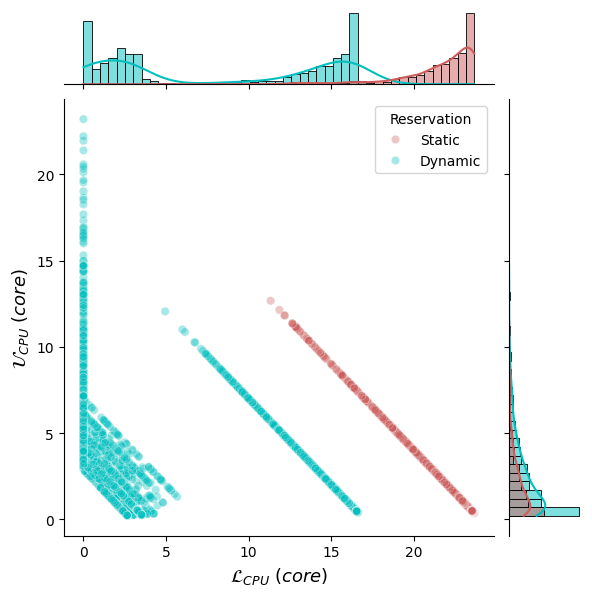

In [7]:
g = sns.JointGrid(data=df, x="lost", y="used", hue="Reservation")
g.plot_joint(sns.scatterplot, alpha=0.35, palette=colors_palette)
g.plot_marginals(sns.histplot, binwidth=0.5, kde=True, palette=colors_palette)

g.ax_joint.set_xlabel(r"$\mathcal{L}_{CPU}$ $(core)$", fontsize=13)
g.ax_joint.set_ylabel(r"$\mathcal{U}_{CPU}$ $(core)$", fontsize=13)

plt.gcf().savefig(
    "figures/wasted_resources/lost_cpu_correlation.pdf", bbox_inches="tight"
)

# Stolen resources


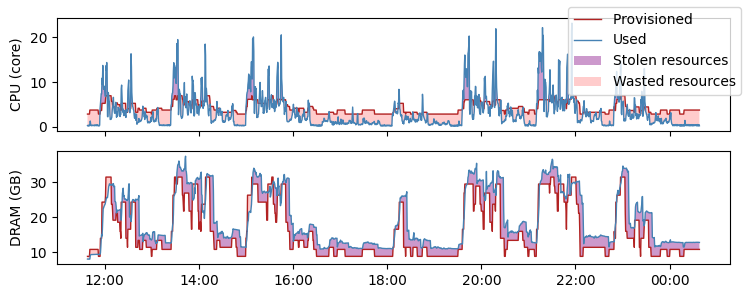

In [8]:
fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, sharey=False)

row = 0

architecture = "K8S"

for computing_resource in COMPUTING_RESOURCES:
    reserved = reserved_resources[architecture]
    used = used_resources[architecture]
    ax = axes[row]
    ax.plot_date(
        reserved["Time"],
        reserved[computing_resource],
        "-",
        label="Provisioned  ",
        linewidth=1,
        color=RESERVED_COLOR,
    )
    ax.plot_date(
        used["Time"],
        used[computing_resource],
        "-",
        label="Used",
        linewidth=1,
        color=USED_COLOR,
    )

    ax.fill_between(
        reserved["Time"],
        reserved[computing_resource],
        used[computing_resource],
        where=used[computing_resource] >= reserved[computing_resource],
        facecolor="purple",
        alpha=0.4,
        interpolate=True,
        label="Stolen resources",
    )

    ax.fill_between(
        reserved["Time"],
        reserved[computing_resource],
        used[computing_resource],
        where=reserved[computing_resource] >= used[computing_resource],
        facecolor="red",
        alpha=0.2,
        interpolate=True,
        label="Wasted resources",
    )

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    # if row == 0:
    #     if architecture == "KVM":
    #         ax.set_title("Static")
    #     else:
    #         ax.set_title("Dynamic")
    # if col == 0:
    if computing_resource == "CPU":
        ax.set_ylabel("CPU (core)")
    else:
        ax.set_ylabel("DRAM (GB)")
    row += 1

fig.set_size_inches((FIG_WIDTH / 2, FIG_HEIGHT * 0.6))
# plt.xlabel("Time")
# plt.title('Lost resources')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
# fig.suptitle("Lost resources")

# plt.xlim(left=0)
# plt.ylim(bottom=0)
plt.tight_layout()
# plt.show()

plt.gcf().savefig("figures/stolen_resources/stolen_resources.pdf", bbox_inches="tight")

# Updated KVM


In [9]:
reserved_resources["KVM LIMITS"]["Time"]

0      2024-04-12 07:26:00
1      2024-04-12 07:26:30
2      2024-04-12 07:27:00
3      2024-04-12 07:27:30
4      2024-04-12 07:28:00
               ...        
1556   2024-04-12 20:24:00
1557   2024-04-12 20:24:30
1558   2024-04-12 20:25:00
1559   2024-04-12 20:25:30
1560   2024-04-12 20:26:00
Name: Time, Length: 1561, dtype: datetime64[ns]

In [10]:
reserved_resources["KVM"]["Time"]

0      2024-04-09 07:26:00
1      2024-04-09 07:26:30
2      2024-04-09 07:27:00
3      2024-04-09 07:27:30
4      2024-04-09 07:28:00
               ...        
1556   2024-04-09 20:24:00
1557   2024-04-09 20:24:30
1558   2024-04-09 20:25:00
1559   2024-04-09 20:25:30
1560   2024-04-09 20:26:00
Name: Time, Length: 1561, dtype: datetime64[ns]

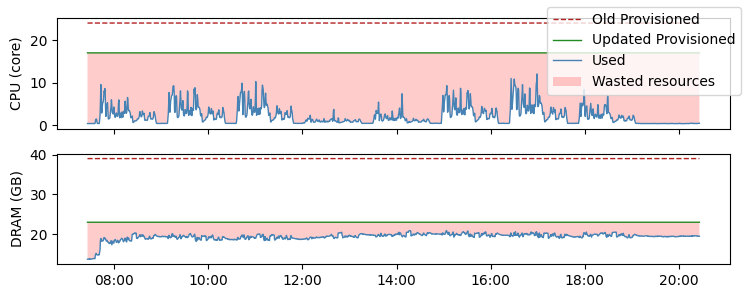

In [11]:
fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, sharey=False)

row = 0

architecture = "KVM LIMITS"

for computing_resource in COMPUTING_RESOURCES:
    reserved = reserved_resources[architecture]
    used = used_resources[architecture]
    ax = axes[row]

    ax.plot_date(
        reserved["Time"],
        reserved_resources["KVM"][computing_resource],
        "--",
        label="Old Provisioned",
        linewidth=1,
        color=RESERVED_COLOR,
    )

    ax.plot_date(
        reserved["Time"],
        reserved[computing_resource],
        "-",
        label="Updated Provisioned",
        linewidth=1,
        color="forestgreen",
    )
    ax.plot_date(
        used["Time"],
        used[computing_resource],
        "-",
        label="Used",
        linewidth=1,
        color=USED_COLOR,
    )

    ax.fill_between(
        reserved["Time"],
        reserved[computing_resource],
        used[computing_resource],
        where=reserved[computing_resource] >= used[computing_resource],
        facecolor="red",
        alpha=0.2,
        interpolate=True,
        label="Wasted resources",
    )
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    # if row == 0:
    #     if architecture == "KVM":
    #         ax.set_title("Static")
    #     else:
    #         ax.set_title("Dynamic")
    # if col == 0:
    if computing_resource == "CPU":
        ax.set_ylabel("CPU (core)")
    else:
        ax.set_ylabel("DRAM (GB)")
    row += 1

fig.set_size_inches((FIG_WIDTH / 2, FIG_HEIGHT * 0.6))
# plt.xlabel("Time")
# plt.title('Lost resources')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
# fig.suptitle("Lost resources")

# plt.xlim(left=0)
# plt.ylim(bottom=0)
plt.tight_layout()
# plt.show()

plt.gcf().savefig("figures/wasted_resources/kvm_updated.pdf", bbox_inches="tight")

## Percentages


In [12]:
print("Memory Lost:")
old = sum(lost_resources["KVM"]["Memory"])
new = sum(lost_resources["KVM LIMITS"]["Memory"])
percentage = ((old - new) * 100) / old

print("Old: " + str(old))
print("New: " + str(new))
print("Percentage: " + str(percentage))

print()

print("CPU Lost")
old = sum(lost_resources["KVM"]["CPU"])
new = sum(lost_resources["KVM LIMITS"]["CPU"])
percentage = ((old - new) * 100) / old

print("Old: " + str(old))
print("New: " + str(new))
print("Percentage: " + str(percentage))

Memory Lost:
Old: 29538.669199359996
New: 5630.285443071997
Percentage: 80.93927182341044

CPU Lost
Old: 33804.320614568656
New: 22972.39987405775
Percentage: 32.04300676240383


# Stolen versus waste


In [13]:
stolen_vs_waste = {}
stolen_vs_waste["KVM"] = {
    "Lost": {
        "Memory": sum(lost_resources["KVM"]["Memory"]),
        "CPU": sum(lost_resources["KVM"]["CPU"]),
    },
    "Stolen": {
        "Memory": sum(stolen_resources["KVM"]["Memory"]),
        "CPU": sum(stolen_resources["KVM"]["CPU"]),
    },
}
stolen_vs_waste["K8S"] = {
    "Lost": {
        "Memory": sum(lost_resources["K8S"]["Memory"]),
        "CPU": sum(lost_resources["K8S"]["CPU"]),
    },
    "Stolen": {
        "Memory": sum(stolen_resources["K8S"]["Memory"]),
        "CPU": sum(stolen_resources["K8S"]["CPU"]),
    },
}

data = stolen_vs_waste
stolen_vs_waste

{'KVM': {'Lost': {'Memory': 29538.669199359996, 'CPU': 33804.320614568656},
  'Stolen': {'Memory': 0.0, 'CPU': 0.0}},
 'K8S': {'Lost': {'Memory': 505.49861375999996, 'CPU': 2669.3911424238704},
  'Stolen': {'Memory': 5576.982557311994, 'CPU': 1212.0202732851478}}}

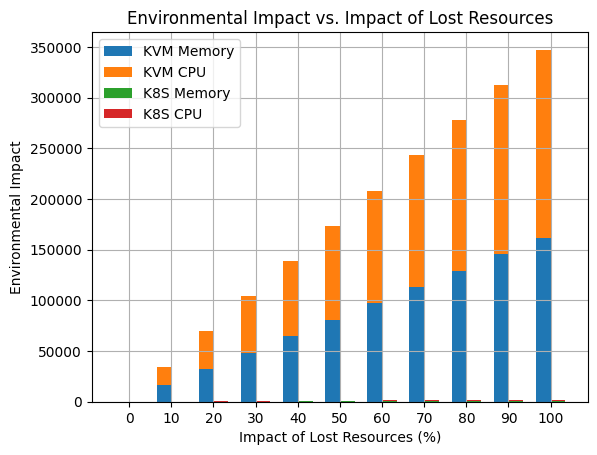

In [14]:
import numpy as np

# Data
data = {
    "KVM": {
        "Lost": {"Memory": 161557.88454297648, "CPU": 185813.76003728152},
        "Stolen": {"Memory": 0.0, "CPU": 0.0},
    },
    "K8S": {
        "Lost": {"Memory": 560.5111370239995, "CPU": 1588.5760960025784},
        "Stolen": {"Memory": 1724.6231074559976, "CPU": 495.45914393975374},
    },
}

# Impact of lost resources
lost_impact_range = [i for i in range(0, 110, 10)]  # 0 to 100 with step size 10

# Calculate environmental impact for each platform and resource
kvm_memory_impact = [
    data["KVM"]["Lost"]["Memory"] * (impact / 100) for impact in lost_impact_range
]
kvm_cpu_impact = [
    data["KVM"]["Lost"]["CPU"] * (impact / 100) for impact in lost_impact_range
]
k8s_memory_impact = [
    data["K8S"]["Lost"]["Memory"] * (impact / 100) for impact in lost_impact_range
]
k8s_cpu_impact = [
    data["K8S"]["Lost"]["CPU"] * (impact / 100) for impact in lost_impact_range
]

# Plot
bar_width = 0.35
index = np.arange(len(lost_impact_range))

plt.bar(index, kvm_memory_impact, bar_width, label="KVM Memory")
plt.bar(index, kvm_cpu_impact, bar_width, label="KVM CPU", bottom=kvm_memory_impact)
plt.bar(index + bar_width, k8s_memory_impact, bar_width, label="K8S Memory")
plt.bar(
    index + bar_width,
    k8s_cpu_impact,
    bar_width,
    label="K8S CPU",
    bottom=k8s_memory_impact,
)

plt.xlabel("Impact of Lost Resources (%)")
plt.ylabel("Environmental Impact")
plt.title("Environmental Impact vs. Impact of Lost Resources")
plt.xticks(index + bar_width / 2, lost_impact_range)
plt.legend()
plt.grid(True)
plt.show()

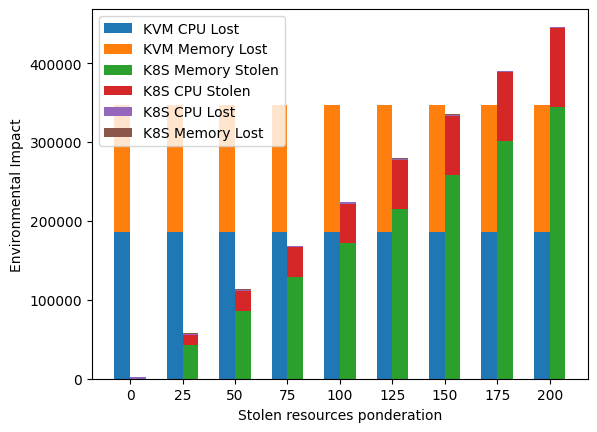

In [15]:
ponderation = [i for i in range(0, 225, 25)]  # 0 to 100 with step size 10

# For each of ponderation, we multiply lost resources

# Calculate environmental impact for each platform and resource
kvm_memory_stolen = [data["KVM"]["Stolen"]["Memory"] * p for p in ponderation]
kvm_cpu_stolen = [data["KVM"]["Stolen"]["CPU"] * p for p in ponderation]
kvm_memory_lost = [data["KVM"]["Lost"]["Memory"]] * len(ponderation)
kvm_cpu_lost = [data["KVM"]["Lost"]["CPU"]] * len(ponderation)

k8s_memory_stolen = [data["K8S"]["Stolen"]["Memory"] * p for p in ponderation]
k8s_cpu_stolen = [data["K8S"]["Stolen"]["CPU"] * p for p in ponderation]
k8s_memory_lost = [data["K8S"]["Lost"]["Memory"]] * len(ponderation)
k8s_cpu_lost = [data["K8S"]["Lost"]["CPU"]] * len(ponderation)

# Plot
bar_width = 0.3
index = np.arange(len(ponderation))

# KVM
# plt.bar(index, kvm_memory_stolen, bar_width, label="KVM Memory Stolen")
# plt.bar(
#     index, kvm_cpu_stolen, bar_width, label="KVM CPU Stolen", bottom=kvm_memory_stolen
# )
plt.bar(
    index,
    kvm_cpu_lost,
    bar_width,
    label="KVM CPU Lost",
    bottom=[x + y for x, y in zip(kvm_memory_stolen, kvm_cpu_stolen)],
)
plt.bar(
    index,
    kvm_memory_lost,
    bar_width,
    label="KVM Memory Lost",
    bottom=[
        x + y + z for x, y, z in zip(kvm_memory_stolen, kvm_cpu_stolen, kvm_cpu_lost)
    ],
)

# K8S
plt.bar(index + bar_width, k8s_memory_stolen, bar_width, label="K8S Memory Stolen")
plt.bar(
    index + bar_width,
    k8s_cpu_stolen,
    bar_width,
    label="K8S CPU Stolen",
    bottom=k8s_memory_stolen,
)
plt.bar(
    index + bar_width,
    k8s_cpu_lost,
    bar_width,
    label="K8S CPU Lost",
    bottom=[x + y for x, y in zip(k8s_memory_stolen, k8s_cpu_stolen)],
)
plt.bar(
    index + bar_width,
    k8s_memory_lost,
    bar_width,
    label="K8S Memory Lost",
    bottom=[
        x + y + z for x, y, z in zip(k8s_memory_stolen, k8s_cpu_stolen, k8s_cpu_lost)
    ],
)

plt.xlabel("Stolen resources ponderation")
plt.ylabel("Environmental Impact")
# plt.title("Environmental Impact vs. Impact of Lost Resources")
plt.xticks(index + bar_width / 2, ponderation)
plt.legend()
# plt.grid(True)
plt.show()

# By component

We start by computing shares instead of absolute values, to be able to have ram and cpu on the same figure


In [16]:
k8s_col_to_aggregate = ["gitlab-shell", "prometheus", "gitlab-exporter"]

# KVM


In [17]:
lost = {}

for architecture in ARCHITECTURES:
    lost[architecture] = {}
    for computing_resource in COMPUTING_RESOURCES:
        lost[architecture][computing_resource] = {}
        infra = lost_resources_by_label[architecture][computing_resource]

        if architecture == "KVM":
            infra["Gitlab"] = infra["rails_1"] + infra["rails_2"]
            infra.pop("rails_1")
            infra.pop("rails_2")
        elif architecture == "K8S":
            infra["Others"] = infra[k8s_col_to_aggregate].sum(axis=1)
            infra = infra.drop(columns=k8s_col_to_aggregate, axis=1)

        # Sum all columns
        for col in infra:
            lost[architecture][computing_resource][col] = infra[col].sum()

# kvm_lost

In [18]:
lost

{'K8S': {'CPU': {'gitaly': 81.85012944887751,
   'kas': 305.05986155176583,
   'minio': 233.86766829850535,
   'registry': 154.7296996268267,
   'sidekiq': 1691.8139247880067,
   'toolbox': 78.04871596451959,
   'webservice': 613.9226411381053,
   'postgresql': 181.67146150031243,
   'redis': 0,
   'Others': 104.83258292181429},
  'Memory': {'gitaly': 0.0,
   'kas': 124.34877900800001,
   'minio': 84.69556428800001,
   'registry': 8.815894528000005,
   'sidekiq': 684.41764352,
   'toolbox': 272.309046656,
   'webservice': 618.830767104,
   'postgresql': 5.544955904000003,
   'redis': 0,
   'Others': 35.00169548800001}},
 'KVM': {'CPU': {'Redis': 2960.290682569541,
   'PostgreSQL': 2791.1131518653583,
   'Gitaly': 5871.085230908101,
   'Gitlab': 22181.83154922568},
  'Memory': {'Redis': 2660.7206154240002,
   'PostgreSQL': 7402.008281087999,
   'Gitaly': 17768.406392832,
   'Gitlab': 1707.5339100160002}}}

In [19]:
used = {}

for architecture in ARCHITECTURES:
    used[architecture] = {}
    for computing_resource in COMPUTING_RESOURCES:
        used[architecture][computing_resource] = {}
        infra = used_resources_by_label[architecture][computing_resource]

        if architecture == "KVM":
            infra["Gitlab"] = infra["rails_1"] + infra["rails_2"]
            infra.pop("rails_1")
            infra.pop("rails_2")
        elif architecture == "K8S":
            infra["Others"] = infra[k8s_col_to_aggregate].sum(axis=1)
            infra = infra.drop(columns=k8s_col_to_aggregate, axis=1)

        # Sum all columns
        for col in infra:
            used[architecture][computing_resource][col] = infra[col].sum()

# kvm_lost

In [20]:
used

{'K8S': {'CPU': {'gitaly': 594.428611189067,
   'kas': 7.140138448234191,
   'minio': 0.28233170149465103,
   'registry': 1.3703003731733192,
   'sidekiq': 274.6860752119932,
   'toolbox': 0.001284035480408,
   'webservice': 3666.84671559235,
   'postgresql': 464.442639009727,
   'redis': 66.121790879788,
   'Others': 108.78424441996441},
  'Memory': {'gitaly': 1332.383604736,
   'kas': 31.851220992000002,
   'minio': 20.12848128,
   'registry': 43.596128256,
   'sidekiq': 1493.5823564799998,
   'toolbox': 1.0409533439999998,
   'webservice': 9018.376298496001,
   'postgresql': 286.01953484800003,
   'redis': 47.894028288,
   'Others': 1410.7014184959999}},
 'KVM': {'CPU': {'Redis': 161.70931743045884,
   'PostgreSQL': 330.88684813464164,
   'Gitaly': 372.9147690918992,
   'Gitlab': 2794.168450774321},
  'Memory': {'Redis': 2919.076032512,
   'PostgreSQL': 3929.5989227520004,
   'Gitaly': 5067.653124095999,
   'Gitlab': 19408.987549696}}}

In [21]:
lost_percentage = {}
used_percentage = {}

for architecture in ARCHITECTURES:
    lost_percentage[architecture] = {}
    used_percentage[architecture] = {}
    for computing_resource in COMPUTING_RESOURCES:
        lost_percentage[architecture][computing_resource] = {}
        used_percentage[architecture][computing_resource] = {}

        component_total = sum(used[architecture][computing_resource].values())
        for key, value in used[architecture][computing_resource].items():
            used_total = used[architecture][computing_resource][key]
            lost_total = lost[architecture][computing_resource][key]

            component_total = used_total + lost_total

            used_percentage[architecture][computing_resource][key] = (
                used_total * 100.0
            ) / component_total
            lost_percentage[architecture][computing_resource][key] = (
                lost_total * 100.0
            ) / component_total

In [22]:
used_percentage

{'K8S': {'CPU': {'gitaly': 87.8969832214943,
   'kas': 2.287039861702175,
   'minio': 0.12057728016000471,
   'registry': 0.8778349603929015,
   'sidekiq': 13.968272321993044,
   'toolbox': 0.0016451447538859707,
   'webservice': 85.6585910153542,
   'postgresql': 71.88244903541003,
   'redis': 100.0,
   'Others': 50.92494152902749},
  'Memory': {'gitaly': 100.0,
   'kas': 20.391306653008964,
   'minio': 19.20216031630121,
   'registry': 83.17963310759443,
   'sidekiq': 68.57586577043158,
   'toolbox': 0.38081336894091816,
   'webservice': 93.57873331047419,
   'postgresql': 98.09820602992549,
   'redis': 100.0,
   'Others': 97.57891539767498}},
 'KVM': {'CPU': {'Redis': 5.179670641590611,
   'PostgreSQL': 10.598553751910366,
   'Gitaly': 5.972369780459629,
   'Gitlab': 11.187413720268742},
  'Memory': {'Redis': 52.31509706705501,
   'PostgreSQL': 34.67821335547492,
   'Gitaly': 22.191451727209902,
   'Gitlab': 91.91375381937888}}}

# K8S


# Plots


In [23]:
lost_percentage["K8S"]

{'CPU': {'gitaly': 12.103016778505705,
  'kas': 97.71296013829782,
  'minio': 99.87942271984,
  'registry': 99.12216503960711,
  'sidekiq': 86.03172767800694,
  'toolbox': 99.9983548552461,
  'webservice': 14.341408984645792,
  'postgresql': 28.117550964589977,
  'redis': 0.0,
  'Others': 49.075058470972515},
 'Memory': {'gitaly': 0.0,
  'kas': 79.60869334699103,
  'minio': 80.7978396836988,
  'registry': 16.820366892405577,
  'sidekiq': 31.42413422956841,
  'toolbox': 99.61918663105908,
  'webservice': 6.421266689525803,
  'postgresql': 1.9017939700745148,
  'redis': 0.0,
  'Others': 2.4210846023250236}}

In [24]:
used_percentage["K8S"]

{'CPU': {'gitaly': 87.8969832214943,
  'kas': 2.287039861702175,
  'minio': 0.12057728016000471,
  'registry': 0.8778349603929015,
  'sidekiq': 13.968272321993044,
  'toolbox': 0.0016451447538859707,
  'webservice': 85.6585910153542,
  'postgresql': 71.88244903541003,
  'redis': 100.0,
  'Others': 50.92494152902749},
 'Memory': {'gitaly': 100.0,
  'kas': 20.391306653008964,
  'minio': 19.20216031630121,
  'registry': 83.17963310759443,
  'sidekiq': 68.57586577043158,
  'toolbox': 0.38081336894091816,
  'webservice': 93.57873331047419,
  'postgresql': 98.09820602992549,
  'redis': 100.0,
  'Others': 97.57891539767498}}

In [25]:
# Order by largest lost percentage

ordered = {}

for architecture in ARCHITECTURES:
    ordered[architecture] = {}
    for computing_resource in COMPUTING_RESOURCES:
        for component in used_percentage[architecture][computing_resource]:
            if component not in ordered[architecture]:
                ordered[architecture][component] = 0

            ordered[architecture][component] += used_percentage[architecture][
                computing_resource
            ][component]

    ordered[architecture] = dict(
        sorted(ordered[architecture].items(), key=lambda x: x[1])
    )

ordered

{'K8S': {'toolbox': 0.38245851369480416,
  'minio': 19.322737596461216,
  'kas': 22.67834651471114,
  'sidekiq': 82.54413809242462,
  'registry': 84.05746806798733,
  'Others': 148.50385692670247,
  'postgresql': 169.98065506533553,
  'webservice': 179.2373243258284,
  'gitaly': 187.89698322149428,
  'redis': 200.0},
 'KVM': {'Gitaly': 28.16382150766953,
  'PostgreSQL': 45.27676710738528,
  'Redis': 57.49476770864562,
  'Gitlab': 103.10116753964762}}

In [26]:
ordered_lost_percentage = {}
ordered_used_percentage = {}

for architecture in ARCHITECTURES:
    ordered_lost_percentage[architecture] = {}
    ordered_used_percentage[architecture] = {}
    for computing_resource in COMPUTING_RESOURCES:
        ordered_lost_percentage[architecture][computing_resource] = {}
        ordered_used_percentage[architecture][computing_resource] = {}
        for component in ordered[architecture]:
            ordered_lost_percentage[architecture][computing_resource][component] = (
                lost_percentage[architecture][computing_resource][component]
            )
            ordered_used_percentage[architecture][computing_resource][component] = (
                used_percentage[architecture][computing_resource][component]
            )

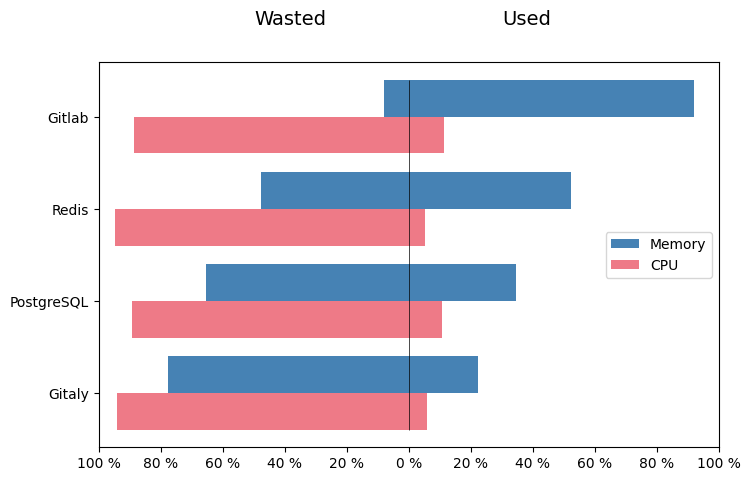

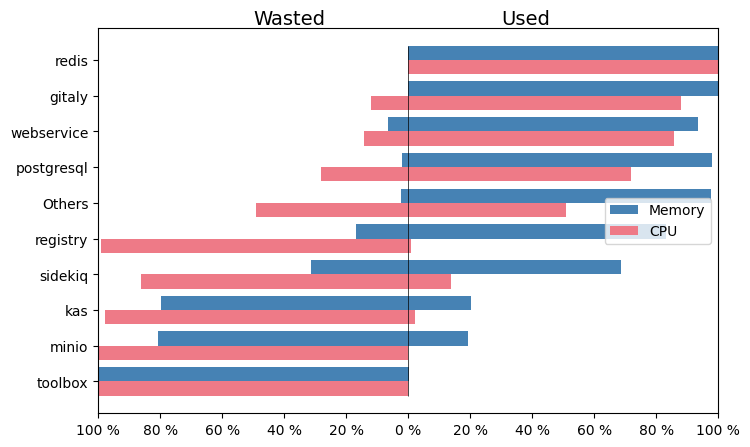

In [27]:
def plot_population(
    fig_name,
    labels,
    lost,
    consumed,
):
    height = 0.1
    margin = 0.25
    cpu_color = "#ee7a87"
    memory_color = "#4682b4"

    # Convert consumed values to negative to go left
    lost_cpu_inversed = []
    for component in lost["CPU"]:
        if lost["CPU"][component] > 0:
            lost_cpu_inversed.append(-lost["CPU"][component])
        else:
            lost_cpu_inversed.append(0)

    lost_memory_inversed = []
    for component in lost["Memory"]:
        if lost["Memory"][component] > 0:
            lost_memory_inversed.append(-lost["Memory"][component])
        else:
            lost_memory_inversed.append(0)

    fig = plt.figure()

    y_axis = []
    for i in range(len(labels)):
        y_axis.append(i * margin)

    memory_axis = []
    cpu_axis = []

    for i in y_axis:
        memory_axis.append(i + (height / 2))
        cpu_axis.append(i - (height / 2))

    fig.set_size_inches((8, 5))

    plt.barh(
        y=memory_axis,
        width=consumed["Memory"].values(),
        color=memory_color,
        label="Memory",
        height=height,
    )
    plt.barh(
        y=cpu_axis,
        width=consumed["CPU"].values(),
        color=cpu_color,
        label="CPU",
        height=height,
    )

    plt.barh(
        y=memory_axis,
        width=lost["Memory"].values(),
        left=lost_memory_inversed,
        color=memory_color,
        height=height,
    )
    plt.barh(
        y=cpu_axis,
        width=lost["CPU"].values(),
        left=lost_cpu_inversed,
        color=cpu_color,
        height=height,
    )

    plt.yticks(ticks=y_axis, labels=labels)
    plt.xlim(-100, 100)
    plt.vlines(0, -height, max(y_axis) + height, colors="black", linewidth=0.5)
    plt.xticks(
        [-100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100],
        [
            "{} %".format(abs(i))
            for i in [-100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100]
        ],
    )

    plt.text(s="Wasted", x=-50, y=len(labels) * margin, fontsize=14)
    plt.text(s="Used", x=30, y=len(labels) * margin, fontsize=14)
    plt.legend(loc="center right")
    plt.gcf().savefig(
        "figures/wasted_resources/wasted_resources_" + fig_name + ".pdf",
        bbox_inches="tight",
    )


plot_population(
    "KVM",
    ordered_lost_percentage["KVM"]["CPU"].keys(),
    ordered_lost_percentage["KVM"],
    ordered_used_percentage["KVM"],
)
plot_population(
    "K8S",
    ordered_lost_percentage["K8S"]["CPU"].keys(),
    ordered_lost_percentage["K8S"],
    ordered_used_percentage["K8S"],
)

# Totals


Durations


In [28]:

pd.DataFrame(used_resources['KVM'])['Time'].max() - pd.DataFrame(used_resources['KVM'])['Time'].min()

Timedelta('0 days 13:00:00')

In [29]:

pd.DataFrame(used_resources['K8S'])['Time'].max() - pd.DataFrame(used_resources['K8S'])['Time'].min()

Timedelta('0 days 13:00:00')

In [30]:
pd.DataFrame(used_resources['KVM'])['Time'].diff()

0                  NaT
1      0 days 00:00:30
2      0 days 00:00:30
3      0 days 00:00:30
4      0 days 00:00:30
             ...      
1556   0 days 00:00:30
1557   0 days 00:00:30
1558   0 days 00:00:30
1559   0 days 00:00:30
1560   0 days 00:00:30
Name: Time, Length: 1561, dtype: timedelta64[ns]

Overall


In [31]:
kvm_cpu = pd.DataFrame(used_resources["KVM"]["CPU"]).sum()[0]
kvm_memory = pd.DataFrame(used_resources["KVM"]["Memory"]).sum()[0]

k8s_cpu = pd.DataFrame(used_resources["K8S"]["CPU"]).sum()[0]
k8s_memory = pd.DataFrame(used_resources["K8S"]["Memory"]).sum()[0]

print(kvm_cpu)
print(kvm_memory)
print(k8s_cpu)
print(k8s_memory)

3659.6793854313214
31325.315629056
5184.104130861273
30328.095354880003


By component


In [32]:
used["K8S"]

{'CPU': {'gitaly': 594.428611189067,
  'kas': 7.140138448234191,
  'minio': 0.28233170149465103,
  'registry': 1.3703003731733192,
  'sidekiq': 274.6860752119932,
  'toolbox': 0.001284035480408,
  'webservice': 3666.84671559235,
  'postgresql': 464.442639009727,
  'redis': 66.121790879788,
  'Others': 108.78424441996441},
 'Memory': {'gitaly': 1332.383604736,
  'kas': 31.851220992000002,
  'minio': 20.12848128,
  'registry': 43.596128256,
  'sidekiq': 1493.5823564799998,
  'toolbox': 1.0409533439999998,
  'webservice': 9018.376298496001,
  'postgresql': 286.01953484800003,
  'redis': 47.894028288,
  'Others': 1410.7014184959999}}

In [33]:
lost["K8S"]

{'CPU': {'gitaly': 81.85012944887751,
  'kas': 305.05986155176583,
  'minio': 233.86766829850535,
  'registry': 154.7296996268267,
  'sidekiq': 1691.8139247880067,
  'toolbox': 78.04871596451959,
  'webservice': 613.9226411381053,
  'postgresql': 181.67146150031243,
  'redis': 0,
  'Others': 104.83258292181429},
 'Memory': {'gitaly': 0.0,
  'kas': 124.34877900800001,
  'minio': 84.69556428800001,
  'registry': 8.815894528000005,
  'sidekiq': 684.41764352,
  'toolbox': 272.309046656,
  'webservice': 618.830767104,
  'postgresql': 5.544955904000003,
  'redis': 0,
  'Others': 35.00169548800001}}